<a href="https://colab.research.google.com/github/Rizariz/ceos-sar-guide/blob/main/03.04.01.Examples_Of_Simple_SAR_Interpretation_Guide_C_Band_L_Band_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.Colab_S1_Data_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data Cube Configuration and Import Utilities

Downloads the odc-colab Python module and runs it to setup ODC.

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2022-01-04 04:11:29--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292 (15K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  14.93K  --.-KB/s    in 0s      

2022-01-04 04:11:29 (82.1 MB/s) - ‘odc_colab.py’ saved [15292/15292]

Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


Downloads an existing index and populates the new ODC environment with it.

In [2]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.
Cleaned up extracted database files.


# Sentinel-1 and ALOS Combined

*This notebook combines two existing viewer notebooks from the ODC Sandbox to allow datasets to be loaded side by side.*

## Sentinel-1 Data Viewer
This notebook is used to review Sentinel-1 data over a specified region. The notebook includes several different data products including single data analysis and multi-date products. This data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter intensity (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction so there are issues using this data in areas with high elevation variation due to layover and shadowing.  
<br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

## ALOS Land Change Notebook
This notebook uses ALOS PALSAR annual mosaics, provided by JAXA, to detect land change. These land changes could be related to agriculture, deforestation, flooding, urbanization, or other factors. This notebook includes several different data products including histograms, a single-date single-band threshold product, and a multi-date land change product. Ten datasets are available from the years: 2007-2010, and 2015-2020. 
The data has been processed to linear amplitude (HH and HV bands) at 25-meters spatial resolution. It should be noted that data collections for a given annual mosaic vary by region but are typically consistent year-to-year.
<br><br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

In [3]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube() #duplicate dc initialisation necessary?



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=eQ1ZPQG1JqNZ9DF8KX2P-J9t-cuYeneXxiHB6Ijtkck&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhYrbRm3QSA7kJtO5-texI2Aj_mlDXs1bQbtRL_r63hriSU8OvAO4w

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
# Select and data platform and product
product_s1 = 's1_google' 
product_alos = 'palsar_google'

## <span id="define_extents">Define the Extents of the Analysis and View [&#9652;](#top)</span>

In [6]:
#@title Choose Example { run: "auto" }
example_name = "4.2.8 Agriculture" #@param ["4.2.1 Dense tropical forest", "4.2.2 Deforestation & regrowth", "4.2.3 Flooded wetlands", "4.2.4 Mangroves", "4.2.5 Rubber", "4.2.6 Oil palm & Acacia", "4.2.7 Irrigated rice", "4.2.8 Agriculture", "4.2.9 Rangelands & pastures", "4.2.10 Savannah", "4.2.11 Arid terrain & rock outcrops", "4.2.12 Open water", "4.2.13 Signal attenuation"]
variable1_name = "C-Band"
variable2_name = "L-Band"
lat_long = ()
box_size_deg = ()
time_extents = ()

if example_name =="4.2.1 Dense tropical forest":
    lat_long = (0.90, -74.20)  # Changed this from 74.20 to -74.20
    box_size_deg = 0.20
    # Time Period
    # Consistent time series data is available from Jan-2017
    time_extents = ('2017-09-29', '2017-10-07') # example_date +/- 9 days
elif example_name=="4.2.2 Deforestation & regrowth":
    lat_long = (1.15, -74.50)  # Changed this from 74.50 to -74.50
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-09-29', '2017-10-07')
elif example_name=="4.2.3 Flooded wetlands":
    lat_long = (-1.90, -74.50)  # Changed this from 1.9 to -1.9 & 74.20 to -74.20
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-20', '2017-03-01') 
elif example_name=="4.2.4 Mangroves":
    lat_long = (-7.80, 39.30)  # Assuming the default as North East
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-08-29', '2017-09-07') 
elif example_name=="4.2.5 Rubber":
    lat_long = (11.15, 106.85)
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-06-10', '2017-06-19') 
elif example_name=="4.2.6 Oil palm & Acacia":
    lat_long = (0.15, 102.95)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-10-01', '2017-10-09') 
elif example_name=="4.2.7 Irrigated rice":
    lat_long = (10.60, 105.55)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-03', '2017-02-12') 
elif example_name=="4.2.8 Agriculture":
    lat_long = (46.95, 7.10)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-09-16', '2017-09-25') 
elif example_name=="4.2.9 Rangelands & pastures":
    lat_long = (-10.05, -51.85)  # Assuming as North East
    box_size_deg = 0.20
    # Time Period
    time_extents = ('2017-08-30', '2017-09-09') 
    #time_extents = ('2017-08-29', '2020-09-01') 
elif example_name=="4.2.10 Savannah":
    lat_long = (-1.45, 34.84)  #Assuming as North East
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-02-23', '2017-03-03') 
elif example_name=="4.2.11 Arid terrain & rock outcrops":
    lat_long = (2.6, 36.80)  # Assuming as North East did not show the exact location
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-10-09', '2017-10-18')
elif example_name=="4.2.12 Open water":
    lat_long = (10.00, 104.75)  
    box_size_deg = 0.20
      # Time Period
    time_extents = ('2017-08-14', '2017-08-23')
elif example_name=="4.2.13 Signal attenuation":
    lat_long = (-2.42,-60.82) #Given S2.25º, W60.75º  
    box_size_deg = 0.30
      # Time Period
    time_extents = ('2017-05-03', '2017-05-29')
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)





In [7]:
 display_map(latitude, longitude)

## Load the Data and View the Available Dates

In [8]:
measurements = dc.list_measurements()
measurements.loc[product_s1]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
VV,VV,float32,,0.0,[single_co_polarization_vertical_transmitorver...,NaN
VH,VH,float32,,0.0,[dual_band_cross_polarization_vertical_transmi...,NaN
angle,angle,float32,Degrees,0.0,"[approximate_viewing_incidence_angle, angle]",NaN


In [9]:
sar_sentinel1_Cband_dataset = dc.load(product=product_s1, measurements=['VV','VH'],
                      time=time_extents, lat=latitude, lon=longitude, group_by='solar_day')

In [10]:
sar_alos_Lband_dataset = dc.load(product=product_alos, measurements=['hh','hv'], time=['2017','2020'], lat=latitude, lon=longitude)


In [11]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_sentinel1_Cband_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])


,Acquisition Date
0,2017-09-17
1,2017-09-18
2,2017-09-19
3,2017-09-23
4,2017-09-24
5,2017-09-25


## View Histogram Plots

In [12]:
# MODIFY HERE
# Choose a single time slice by its index (listed above)
acq_ind_to_show = 0

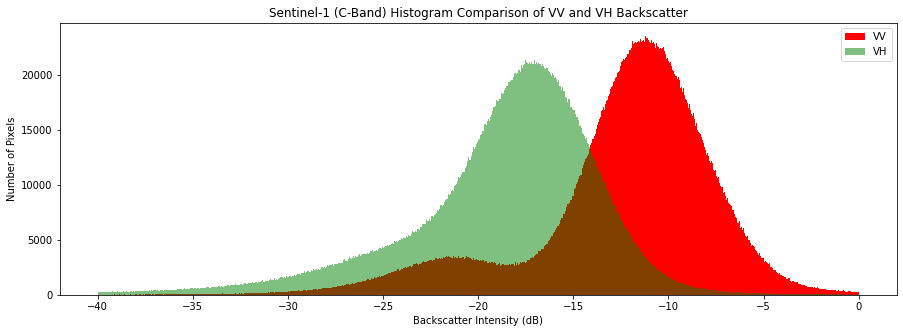

In [13]:
fig = plt.figure(figsize=(15, 5))
sar_sentinel1_Cband_dataset.isel(time=acq_ind_to_show).VV.plot.hist(bins=1000, range=(-40,0), label="VV", facecolor='red')
sar_sentinel1_Cband_dataset.isel(time=acq_ind_to_show).VH.plot.hist(bins=1000, range=(-40,0), label="VH", alpha=0.5, facecolor='green')
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Sentinel-1 (C-Band) Histogram Comparison of VV and VH Backscatter")
plt.show()

In [14]:
year_index = 0

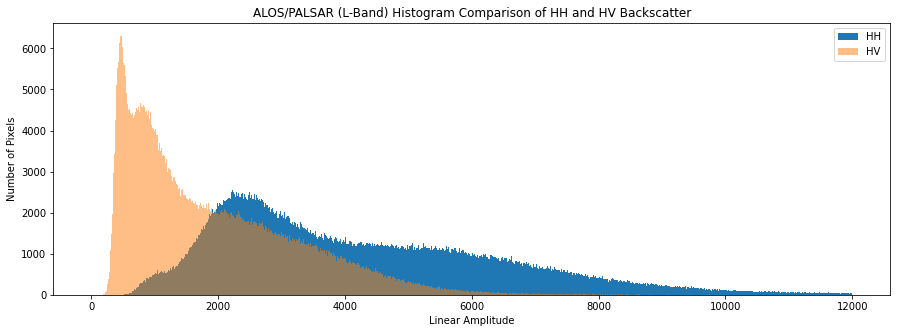

In [15]:
fig = plt.figure(figsize=(15, 5))
sar_alos_Lband_dataset.isel(time=year_index).hh.plot.hist(bins=1000, range=(0,12000), label="HH")
sar_alos_Lband_dataset.isel(time=year_index).hv.plot.hist(bins=1000, range=(0,12000), label="HV", alpha=0.5)
plt.legend()
plt.xlabel("Linear Amplitude")
plt.ylabel("Number of Pixels")
plt.title("ALOS/PALSAR (L-Band) Histogram Comparison of HH and HV Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) is converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [16]:
# Primary VV band range is -2dB to -25dB which is DN=0.79 to DN=0.056
# Primary VH band range is -8dB to -40dB which is DN=0.40 to DN=0.01
# Primary VV/VH range is 0.0 to 1.0. This data is scaled by 60 for improved color contrast

vv_convert = (10**(sar_sentinel1_Cband_dataset.VV/20)-0.056)*350
vh_convert = (10**(sar_sentinel1_Cband_dataset.VH/20)-0.01)*650
sar_sentinel1_Cband_dataset['vv_amp'] = vv_convert
sar_sentinel1_Cband_dataset['vh_amp'] = vh_convert
sar_sentinel1_Cband_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 60

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in HH and HV image products. 

In [17]:
# Creation of a new band (HH/HV = hhhv) for RGB display
sar_alos_Lband_dataset['hhhv'] = sar_alos_Lband_dataset.hh / sar_alos_Lband_dataset.hv

In [18]:
hh = sar_alos_Lband_dataset.hh.astype(np.int64); hh_min = hh.min(); hh_max = hh.max()
sar_alos_Lband_dataset['hh_amp'] = hh*255/12000
hv = sar_alos_Lband_dataset.hv.astype(np.int64); hv_min = hv.min(); hv_max = hv.max()
sar_alos_Lband_dataset['hv_amp'] = hv*255/6000
hhhv = sar_alos_Lband_dataset.hhhv.astype(np.int64); hhhv_min = hhhv.min(); hhhv_max = hhhv.max()
sar_alos_Lband_dataset['hhhv_amp'] = 50*(hh/12000)/(hv/6000)

## VV, VH and RGB images

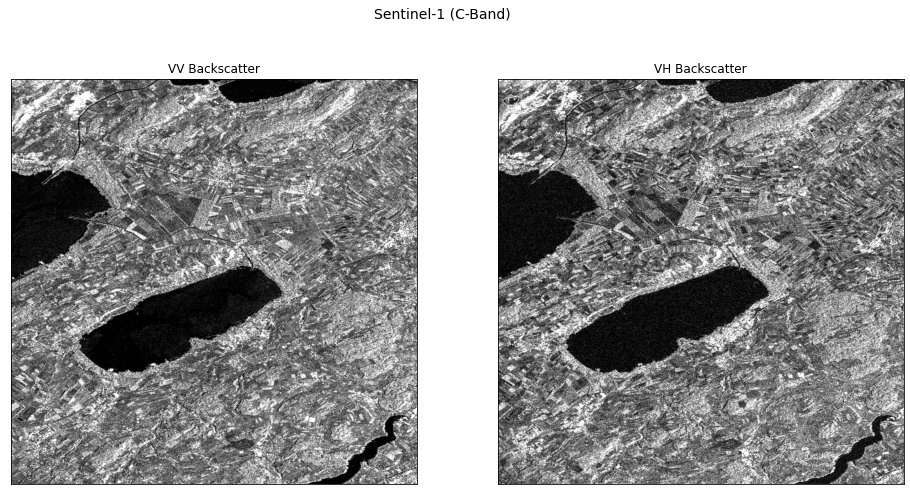

<Figure size 432x288 with 0 Axes>

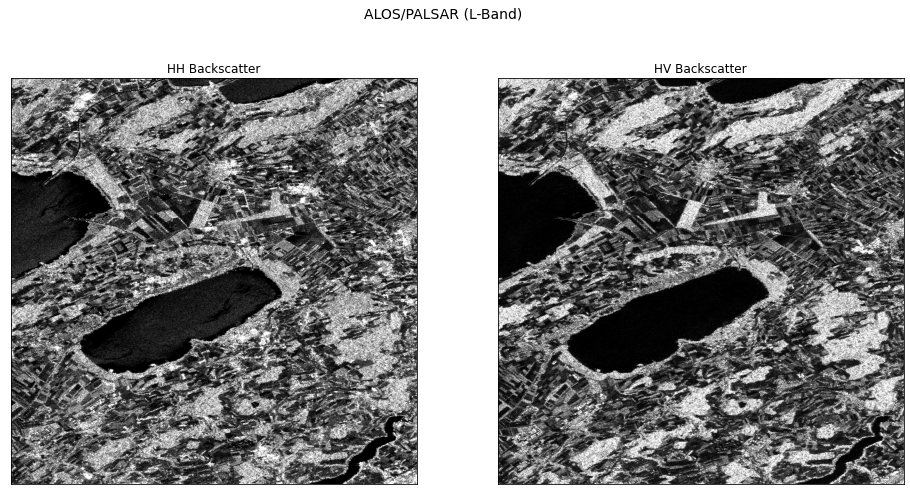

<Figure size 432x288 with 0 Axes>

In [19]:
# Plots of VV and VH Backscatter Intensity C-band
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_sentinel1_Cband_dataset.isel(time=acq_ind_to_show), ax=ax[0], bands=['vv_amp','vv_amp','vv_amp'])
rgb(sar_sentinel1_Cband_dataset.isel(time=acq_ind_to_show), ax=ax[1], bands=['vh_amp','vh_amp','vh_amp'])
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
fig.suptitle('Sentinel-1 (C-Band)',fontsize=14)
plt.show()
plt.tight_layout()


# Plots of HH and HV Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_alos_Lband_dataset.isel(time=year_index), ax=ax[0], bands=['hh_amp','hh_amp','hh_amp'])
rgb(sar_alos_Lband_dataset.isel(time=year_index), ax=ax[1], bands=['hv_amp','hv_amp','hv_amp'])
ax[0].set_title('HH Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('HV Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
fig.suptitle('ALOS/PALSAR (L-Band)', fontsize=14)
plt.show()
plt.tight_layout()


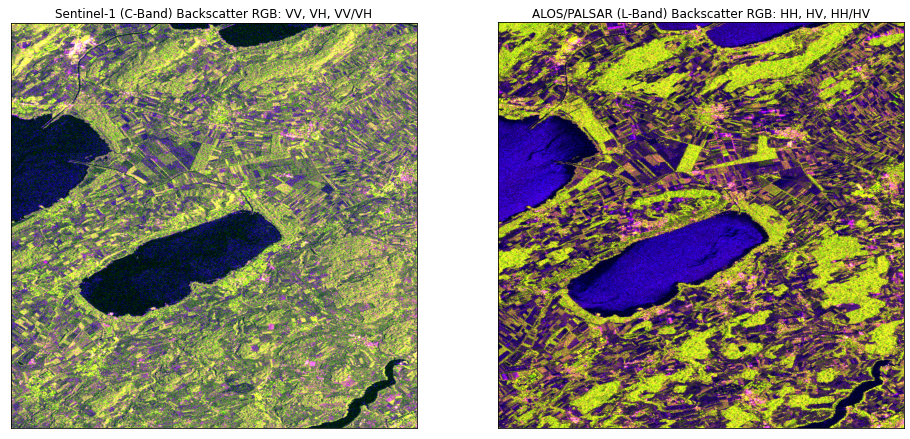

In [20]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is BLACK (low backscatter in both bands with similar VV and VH)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_sentinel1_Cband_dataset.isel(time=acq_ind_to_show), ax=ax[0], bands=['vv_amp','vh_amp','vvvh_amp'])
rgb(sar_alos_Lband_dataset.isel(time=year_index), ax=ax[1], bands=['hh_amp','hv_amp','hhhv_amp'])
ax[0].set_title('Sentinel-1 (C-Band) Backscatter RGB: VV, VH, VV/VH'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ALOS/PALSAR (L-Band) Backscatter RGB: HH, HV, HH/HV'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()


# Want to do more?
Checkout S1 Viewer... TBA